In [3]:
import gymnasium as gym
import torch
import torch.optim as optim
import numpy as np
import time

import matplotlib.pyplot as plt

import my_package
from my_package.core.AC_v4 import AC_agent

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env_name = 'ShipRovCont-v0'
env_options = {
    'generate_random_ship':             True,
    'workspace_safe_distance':          2,
    'ship_scale_factor':                0.9,
    'segments_lenght':                  0.25,
    'frame_per_step':                   10,
    'init_pose':                        None,
    'agent_radius':                     0.25,     # Ho aumentato l' agent radius in training
    'v_surge_max':                      0.1,
    'v_sway_max' :                      0.05,
    'yaw_rel_max':                      np.pi/4,
    'frontal_safe_distance':            0.5,
    'lidar_params':                     {'n_beams': 10, 'max_range': 2.0, 'FoV': np.pi/2},
    'draw_lidar':                       True,
    'max_steps':                        2000
}	

""" Init env """
env = gym.make(env_name, Options=env_options)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

max_episodes = 1000
data_window = 10

buffer_params       = {'buffer_size': 1000000, 'batch_size': 256}
AC_params           = {'learn_every': 16, 'n_learn': 8, 'gamma': 0.99, 'tau': 1e-3, 'lr_actor': 1e-4, 'lr_critic': 1e-4}
noise_type          = 'param'
noise_params        = {'desired_std': 0.5, 'scalar': 0.05, 'scalar_decay': 0.99, 'min_std': 0.01, 'decay_with_ep': True}

""" Init AC agent """
agent = AC_agent(
    state_size=state_dim,
    action_size=action_dim,
    max_episodes=max_episodes,
    device=device,
    noise_params=noise_params,
    noise_type=noise_type,
    AC_params=AC_params,
    buffer_params=buffer_params
)

""" Data collect variables """
total_rewards = np.zeros(max_episodes)
noise_history = np.zeros(max_episodes)
len_episodes = np.zeros(max_episodes)
coverage_per_ep = np.zeros(max_episodes)

In [5]:
start_time = time.time()

for episode in range(max_episodes):
    state, info = env.reset()
    agent.reset(episode)
    done = False
    
    while not done:
        action = agent.act(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        agent.step(state, action, reward, next_state, terminated)

        total_rewards[episode] += reward
        len_episodes[episode] += 1
        state = next_state
        done = terminated or truncated

    coverage_per_ep[episode] = info['coverage']
    
    if episode % data_window == 0 and episode != 0:
        ma_reward = np.mean(total_rewards[episode-data_window:episode])
        ma_coverage = np.mean(coverage_per_ep[episode-data_window:episode])
        print(f"Ep {episode}/{max_episodes}, MA Reward: {ma_reward:.2f}, MA Coverage: {ma_coverage:.1f} %")

env.close()

total_time_seconds = time.time() - start_time
hours = int(total_time_seconds // 3600)
minutes = int((total_time_seconds % 3600) // 60)
seconds = int(total_time_seconds % 60)
print(f"Training finito in: {hours} ore {minutes} minuti e {seconds} secondi")

Ep 10/1000, MA Reward: -25.27, MA Coverage: 2.2 %
Ep 20/1000, MA Reward: -21.28, MA Coverage: 6.5 %
Ep 30/1000, MA Reward: -26.13, MA Coverage: 3.0 %
Ep 40/1000, MA Reward: -26.79, MA Coverage: 5.7 %
Ep 50/1000, MA Reward: -20.52, MA Coverage: 8.3 %
Ep 60/1000, MA Reward: -21.74, MA Coverage: 5.7 %
Ep 70/1000, MA Reward: -25.54, MA Coverage: 0.0 %
Ep 80/1000, MA Reward: -25.79, MA Coverage: 0.0 %
Ep 90/1000, MA Reward: -25.55, MA Coverage: 4.6 %
Ep 100/1000, MA Reward: -26.99, MA Coverage: 6.3 %
Ep 110/1000, MA Reward: -20.88, MA Coverage: 13.7 %
Ep 120/1000, MA Reward: -13.30, MA Coverage: 23.3 %
Ep 130/1000, MA Reward: -15.67, MA Coverage: 22.4 %
Ep 140/1000, MA Reward: -4.49, MA Coverage: 39.1 %
Ep 150/1000, MA Reward: -10.63, MA Coverage: 40.9 %
Ep 160/1000, MA Reward: 42.21, MA Coverage: 49.8 %
Ep 170/1000, MA Reward: 82.09, MA Coverage: 82.0 %
Ep 180/1000, MA Reward: 32.16, MA Coverage: 57.0 %
Ep 190/1000, MA Reward: 27.71, MA Coverage: 48.3 %
Ep 200/1000, MA Reward: 44.04, MA Co

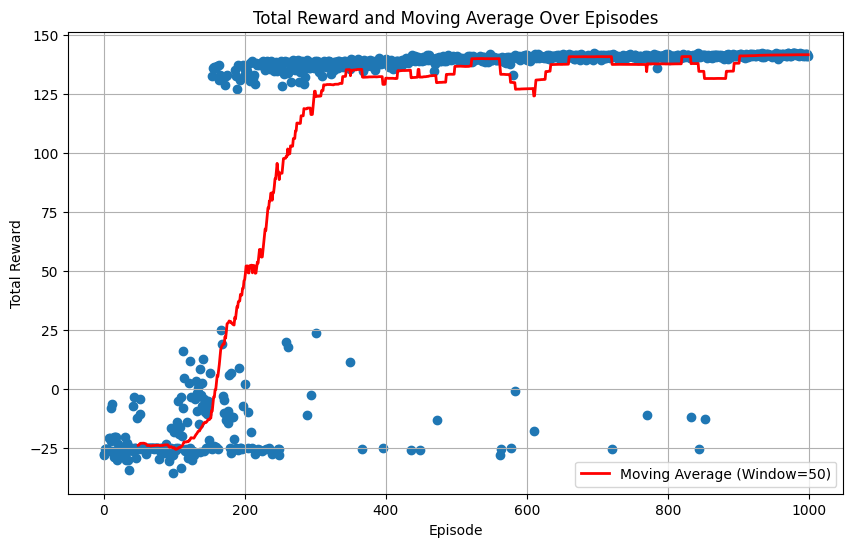

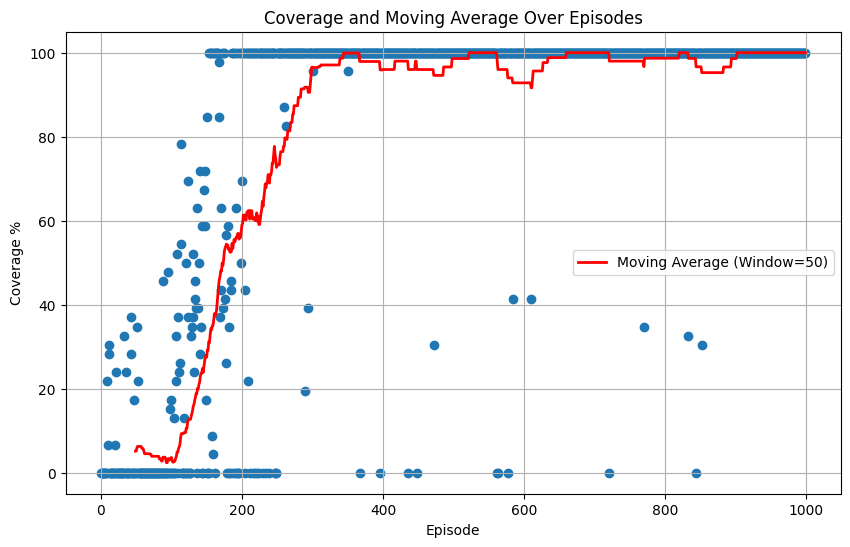

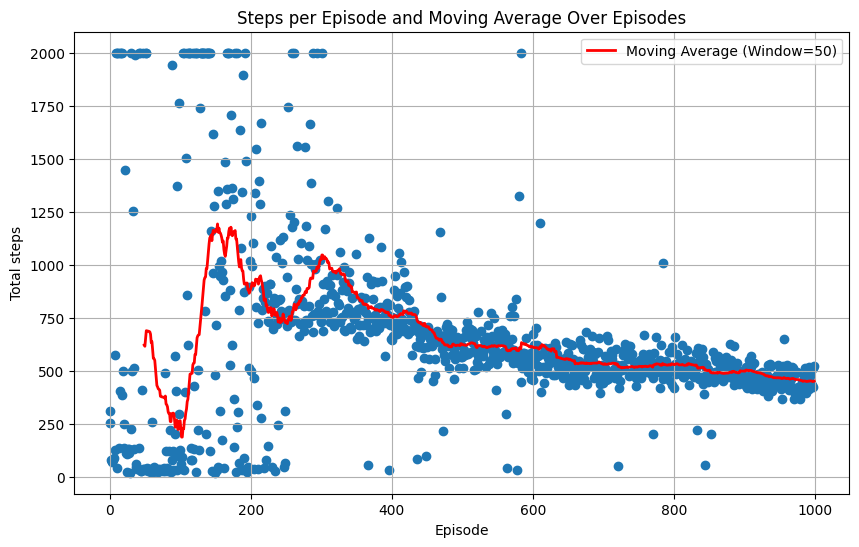

In [6]:
""" Plot rewards """
window_size = 50
ma_reward = np.convolve(total_rewards, np.ones(window_size) / window_size, mode='valid')
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(total_rewards)), total_rewards)
plt.plot(np.arange(window_size - 1, len(total_rewards)), ma_reward, color='red', label=f'Moving Average (Window={window_size})', linewidth=2)
plt.title('Total Reward and Moving Average Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(True)
plt.show()


""" Plot coverage """
window_size = 50
ma_coverage = np.convolve(coverage_per_ep, np.ones(window_size) / window_size, mode='valid')
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(coverage_per_ep)), coverage_per_ep)
plt.plot(np.arange(window_size - 1, len(coverage_per_ep)), ma_coverage, color='red', label=f'Moving Average (Window={window_size})', linewidth=2)
plt.title('Coverage and Moving Average Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Coverage %')
plt.legend()
plt.grid(True)
plt.show()

""" Plot episode duration """
window_size = 50
ma_steps = np.convolve(len_episodes, np.ones(window_size) / window_size, mode='valid')
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(len_episodes)), len_episodes)
plt.plot(np.arange(window_size - 1, max_episodes), ma_steps, color='red', label=f'Moving Average (Window={window_size})', linewidth=2)
plt.title('Steps per Episode and Moving Average Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Total steps')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
trained_env_options = env_options
trained_env_options['agent_radius'] = 0.1
# agent.noise_type = 'normal'
# agent.normal_scalar = 0.0

yaws =[]
v_surges = []
v_sways = []

env = gym.make(env_name, Options=trained_env_options, render_mode='human')

for ep in range(1):
    state, info = env.reset()
    done = False
    total_reward = 0
    steps = 0
    while not done:
        action = agent.act(state, add_noise=False)
        next_state, reward, terminated, truncated, info = env.step(action)
        yaws.append(action[2])
        v_surges.append(action[0])
        v_sways.append(action[1])
        done = terminated or truncated
        state = next_state
        total_reward += reward
        
    if info['collision']:
        ending_cause = "collision"
    elif info['out_of_bounds']:
        ending_cause = "out of bounds"
    elif info['time_limit']:
        ending_cause = "max steps reached"
    elif info['coverage'] == 100:
        ending_cause = "100% coverage"
    else:
        ending_cause = "unkown"
    print('total reward: ' + str(total_reward) + ' end episode for: ' + ending_cause)
env.close()

total reward: 141.95000000000005 end episode for: 100% coverage


In [12]:
env = gym.make(env_name, Options=Options)
yaws =[]
v_surges = []
v_sways = []
for ep in range(1):
    state, info = env.reset()
    agent.reset()
    done = False
    total_reward = 0
    steps = 0
    while not done:
        action = agent.act(state, add_noise=True)
        next_state, reward, terminated, truncated, info = env.step(action)
        yaws.append(action[2])
        v_surges.append(action[0])
        v_sways.append(action[1])
        done = terminated or truncated
        state = next_state
        total_reward += reward
        
    if info['collision']:
        ending_cause = "collision"
    elif info['out_of_bounds']:
        ending_cause = "out of bounds"
    elif info['time_limit']:
        ending_cause = "max steps reached"
    elif info['coverage'] == 100:
        ending_cause = "100% coverage"
    else:
        ending_cause = "unkown"
    print('total reward: ' + str(total_reward) + ' end episode for: ' + ending_cause)
env.close()

NameError: name 'Options' is not defined

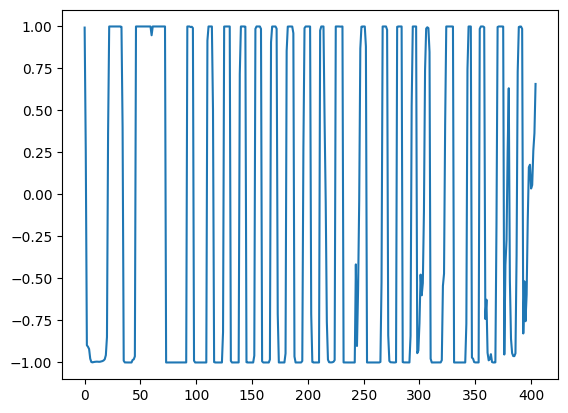

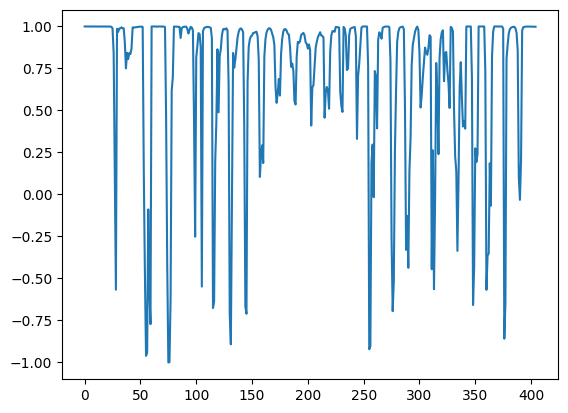

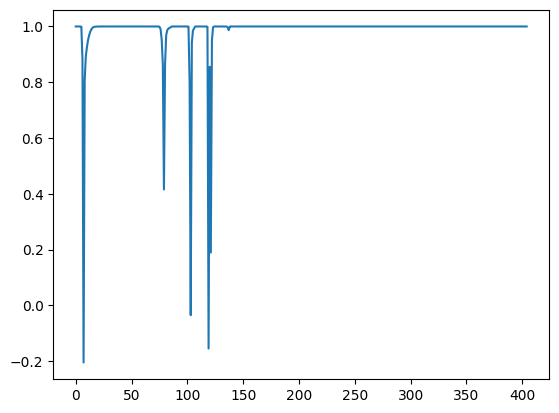

In [18]:
plt.plot(yaws)
plt.show()
plt.plot(v_surges)
plt.show()
plt.plot(v_sways)
plt.show()

In [10]:
noise_type          = 'param'
noise_params = param_noise_params

In [11]:
checkpoint = {
    'state_dim': state_dim,
    'action_dim': action_dim,
    'max_episodes' : max_episodes,
    'buffer_params': buffer_params,
    'noise_type': noise_type,
    'noise_params': noise_params,
    'AC_params': AC_params,
    'actor_state_dict': agent.actor.state_dict(),
    'total_rewards': total_rewards,
    'len_episodes' : len_episodes,
    'coverage_per_ep': coverage_per_ep,
    'env_options' : env_options,
    'trained_env_options': trained_env_options,
    'env_name': env_name,
    'AC_version': 'AC_v3',
}

path = "ShipRovCont-v0/" + env_name + "_" + str(max_episodes) + "_ep_" + "_AC_v4_noise_" + noise_type + ".pth"
torch.save(checkpoint, path)